In [3]:
import numpy as np
import glob,os,warnings,statistics,matplotlib,pickle
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names


"""
Created on Fri Nov 3 12:22:55 2023
@author: giacomo

Analysis of the distributions of outliers in PPP solutions of GNSS time-series 
"""


### folder where there are all the .txt files
cd='/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/data_with_outlier_ratios/'

threshold=4.4478
#ratio of the "absolute_deviation" to the "median_absolute_deviation".  
#In a Hampel filter, you define "outliers"/"spikes" according to some multiple of the ratio between absolute_deviation of a point and the median_absolute_deviation of all points in that window.   
#cut-off of 3x1.4826 = 4.4478. 


def id_names_txt(soln_folder_path):
    """
    Return list of the names of the *txt files inside a folder
    
    Parameters
    ----------
       soln_folder_path: input folder 
    
    Returns
    ---------- 
        List of the names of the files
    """
    
    os.chdir(soln_folder_path)
    names=[]
    for file in glob.glob("*.txt"):
        names.append(file.split('.')[0])
    return sorted(names) 


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """
    Model data by finding best fit distribution to data
    
    Parameters
    ----------
       data: input distribution (array)
       bins: discritization of the data (integer)
       ax: if you want to plot put the axes
    
    Returns
    ----------
    
    """
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax,lw=0.5)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """
    Generate distributions's Probability Distribution Function 
    
    """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


### Count the number of outliers and their characteristics

In [4]:
list_file=id_names_txt(cd)
components=['E', 'N','U']
ratios_columns=['ratio_'+c for c in components]
columns=['year', 'month', 'day']+components+ratios_columns
print(columns)

ratiosStations=[]
ratiosComponents=[[] for i in range(len(ratios_columns))]
indexesComponents=[[] for i in range(len(ratios_columns))]

ind=5
for i in range(len(list_file)):
    in_path = cd+list_file[i]+'.txt'
    df=pd.read_csv(in_path,sep=' ',names=columns)
    df = df.reset_index(drop=True)
    ratiosC=[]
    for k in range(len(ratios_columns)):
        outliers=df[ratios_columns[k]][df[ratios_columns[k]]>threshold]
        outliers.replace([np.inf, -np.inf], np.nan, inplace=True)
        outliers = np.array(outliers[outliers.notnull()])
        ratiosC.append((len(list(outliers))/len(df[ratios_columns[k]]))*100)
        ratiosComponents[k].append(outliers)
        indexes = df[ratios_columns[k]][df[ratios_columns[k]].isin(outliers)].index
        indexes=indexes/len(df) #normalized
        indexesComponents[k].append(indexes)
    ratiosStations.append(ratiosC)
    
    if (i/len(list_file))*100 > ind:
        print(str(ind)+ '%')
        ind+=5
        
for i in  range(len(ratiosComponents)):
    ratiosComponents[i]=np.concatenate(ratiosComponents[i]).ravel() 
    indexesComponents[i]=np.concatenate(indexesComponents[i]).ravel() 
    

['year', 'month', 'day', 'E', 'N', 'U', 'ratio_E', 'ratio_N', 'ratio_U']
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%


### Location of outliers in time with respect to each time-series

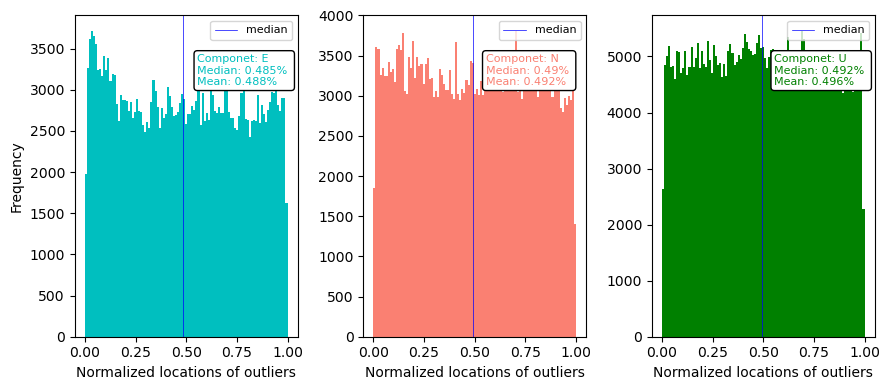

In [5]:
fig, axs = plt.subplots(1,len(components), sharey=False, tight_layout=True,figsize=(9,4))

colors=['c','salmon','g']
bin1=np.linspace(0,1,100)
bin2=np.linspace(0,1,100)
bin3=np.linspace(0,1,100)
binT=[bin1,bin2,bin3]


for z in range(len(components)):
    axs[z].hist(indexesComponents[z],bin3, color=colors[z])
    props = dict(boxstyle='round', facecolor='w', alpha=1)
    axs[z].text(0.55, 0.88, 'Componet: '+str(components[z])+'\nMedian: '+str(round(np.median(indexesComponents[z]),3))+'% \nMean: '+str(round(np.mean(indexesComponents[z]),3))+'%', transform= axs[z].transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[z])
    #axs[z].axvline(x=np.mean(np.array(ratiosComponents[z])),label='mean',color='r',linewidth=0.5)
    axs[z].axvline(x=np.median(indexesComponents[z]),label='median',color='b',linewidth=0.5)
    axs[z].set_xlabel('Normalized locations of outliers')
    #axs[z].set_ylim(0,80000)
    axs[z].legend(loc='upper right',fontsize=8)
    #axs[z].set_xlim(0,1)
axs[0].set_ylabel('Frequency')

fig.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Locations_outliers.pdf')   

### Percentage of outliers for each time-series

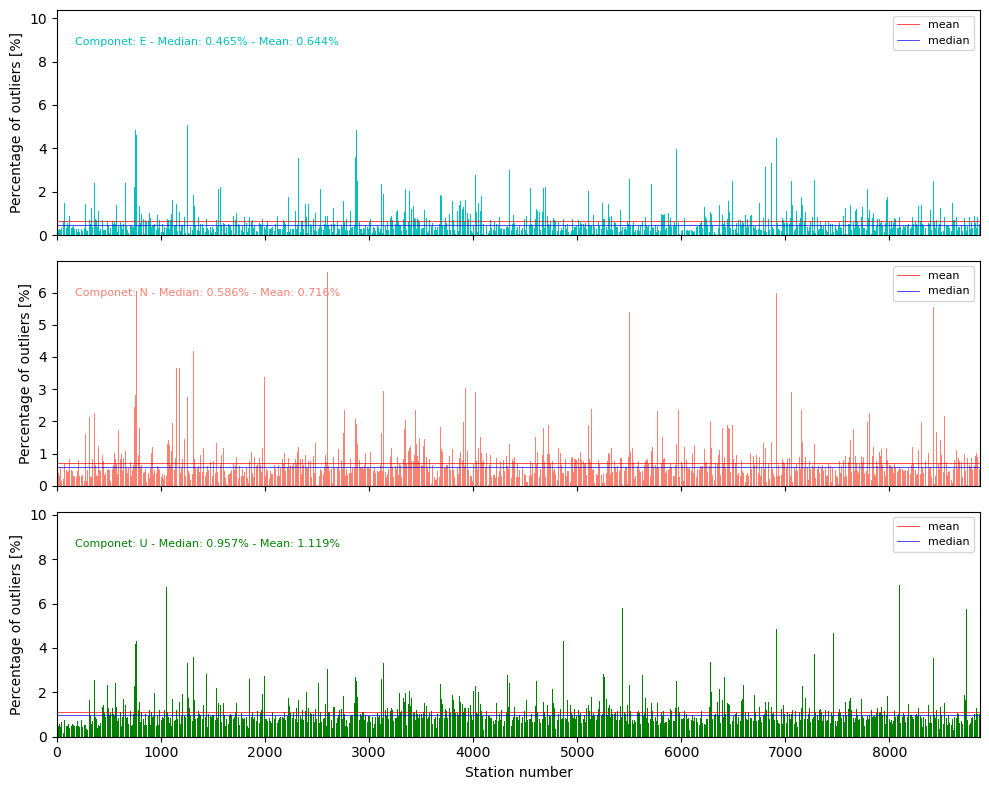

In [48]:
fig, axs = plt.subplots(len(components),1, sharex=True, tight_layout=True,figsize=(10,8))
plt.subplots_adjust(wspace=0, hspace=0)

colors=['c','salmon','g']
for i in range(len(components)):
    axs[i].bar(range(len(np.array(ratiosStations)[:,i])),np.array(ratiosStations)[:,i], color=colors[i])
    axs[i].axhline(y=np.mean(np.array(ratiosStations)[:,i]),label='mean',color='r',linewidth=0.5)
    axs[i].axhline(y=np.median(np.array(ratiosStations)[:,i]),label='median',color='b',linewidth=0.5)
    axs[i].set_xlim(0,len(np.array(ratiosStations)[:,i]))
    props = dict(boxstyle='round', facecolor='k', alpha=0)
    # place a text box in upper left in axes coords
    axs[i].text(0.02, 0.88, 'Componet: '+str(components[i])+' - Median: '+str(round(np.median(np.array(ratiosStations)[:,i]),3))+'% - Mean: '+str(round(np.mean(np.array(ratiosStations)[:,i]),3))+'%', transform= axs[i].transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[i])
    axs[i].legend(loc='upper right',fontsize=8)
    axs[i].set_ylabel('Percentage of outliers [%]')

axs[i].set_xlabel('Station number')
fig.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Stations_%_outliers.pdf')          

### Percentage of outliers per station (Histogram)

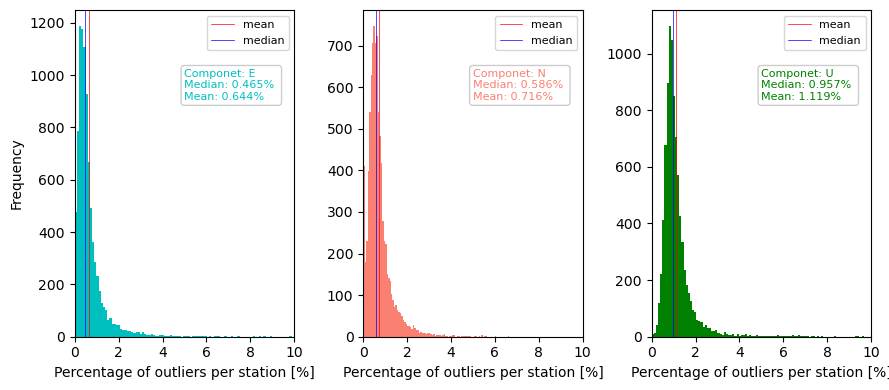

In [73]:
fig, axs = plt.subplots(1,len(components), sharey=False, tight_layout=True,figsize=(9,4))
plt.subplots_adjust(wspace=0, hspace=0)

colors=['c','salmon','g']
for i in range(len(components)):
    axs[i].hist(np.array(ratiosStations)[:,i],100, color=colors[i])
    axs[i].axvline(x=np.mean(np.array(ratiosStations)[:,i]),label='mean',color='r',linewidth=0.5)
    axs[i].axvline(x=np.median(np.array(ratiosStations)[:,i]),label='median',color='b',linewidth=0.5)
    props = dict(boxstyle='round', facecolor='w', alpha=0.2)
    # place a text box in upper left in axes coords
    axs[i].text(0.50, 0.82, 'Componet: '+str(components[i])+'\nMedian: '+str(round(np.median(np.array(ratiosStations)[:,i]),3))+'% \nMean: '+str(round(np.mean(np.array(ratiosStations)[:,i]),3))+'%', transform= axs[i].transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[i])
    axs[i].legend(loc='upper right',fontsize=8)
    axs[i].set_xlim(0,10)
    axs[i].set_xlabel('Percentage of outliers per station [%]')
axs[0].set_ylabel('Frequency')

fig.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Frequency_percentage_outliers.pdf') 

### Fitting Distributions --> Percentage of outliers per station (Histogram)

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

NameError: name 'pickle' is not defined

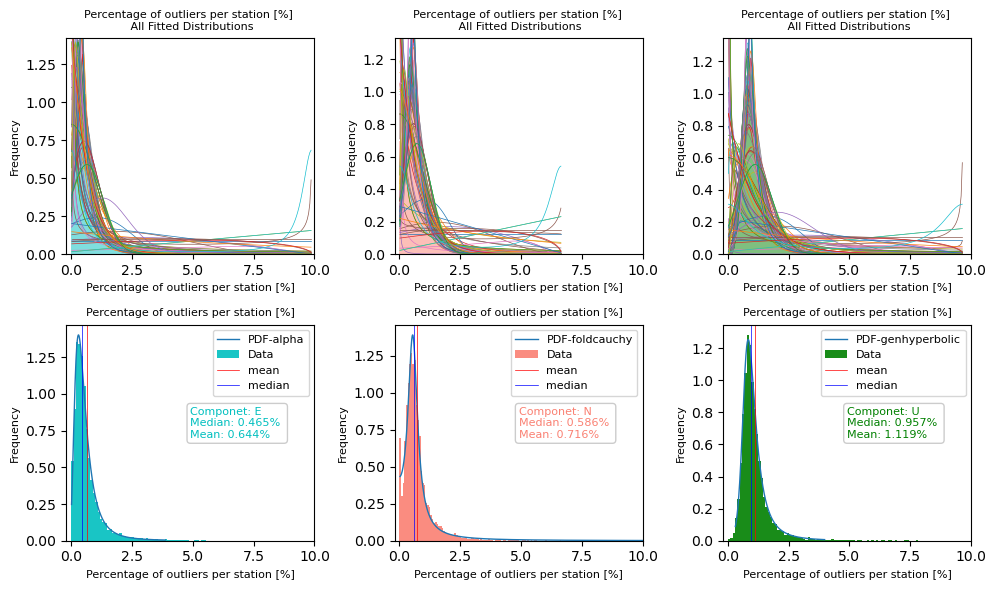

In [6]:
Save_flag_list=False
Save_flag_plot=False

fig, axes = plt.subplots(2,len(components), sharey=False, tight_layout=True,figsize=(10,6))
plt.subplots_adjust(wspace=0, hspace=0)
best_distT=[]

for i in range(len(components)):
    data = pd.Series(np.array(ratiosStations)[:,i]) #[np.array(ratiosStations)[:,i]<10]
    # Plot for comparison
    ax = data.plot(kind='hist', bins=100, density=True,ax=axes[0,i], alpha=0.5, color=colors[i])
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'Percentage of outliers per station [%] \n All Fitted Distributions',fontsize=8)
    ax.set_xlabel(u'Percentage of outliers per station [%]',fontsize=8)
    ax.set_ylabel('Frequency',fontsize=8)
    ax.set_xlim(-0.2,10)


    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    ax2 = pdf.plot(lw=1, ax=axes[1,i],label='PDF-'+str(best_dist[0].name))
    data.plot(kind='hist', bins=100, density=True,ax=axes[1,i], alpha=0.9, label='Data',color=colors[i])

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax2.set_title(u'Percentage of outliers per station [%]',fontsize=8)
    ax2.set_xlabel('Percentage of outliers per station [%]',fontsize=8)
    ax2.set_ylabel('Frequency',fontsize=8)
    ax2.set_xlim(-0.2,10)
    ax2.axvline(x=np.mean(np.array(ratiosStations)[:,i]),label='mean',color='r',linewidth=0.5)
    ax2.axvline(x=np.median(np.array(ratiosStations)[:,i]),label='median',color='b',linewidth=0.5)
    props = dict(boxstyle='round', facecolor='w', alpha=0.2)
    # place a text box in upper left in axes coords
    ax2.text(0.50, 0.62, 'Componet: '+str(components[i])+'\nMedian: '+str(round(np.median(np.array(ratiosStations)[:,i]),3))+'% \nMean: '+str(round(np.mean(np.array(ratiosStations)[:,i]),3))+'%', transform= ax2.transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[i])
    ax2.legend(loc='upper right',fontsize=8)
    best_distT.append(best_dist)

if Save_flag_list==True:
    with open('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Percentage_distributions.pkl', 'wb') as file:
        pickle.dump(best_distT, file)
if Save_flag_plot==True:
    plt.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Percentage_distributions.pdf')

(array([  3.,  14.,  95., 232., 252., 153.,  89.,  60.,  32.,  21.,  18.,
          8.,   4.,   1.,   6.,   2.,   2.,   4.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.75034159, -0.5262926 , -0.3022436 , -0.07819461,  0.14585438,
         0.36990338,  0.59395237,  0.81800136,  1.04205036,  1.26609935,
         1.49014834,  1.71419734,  1.93824633,  2.16229532,  2.38634432,
         2.61039331,  2.8344423 ,  3.0584913 ,  3.28254029,  3.50658928,
         3.73063828,  3.95

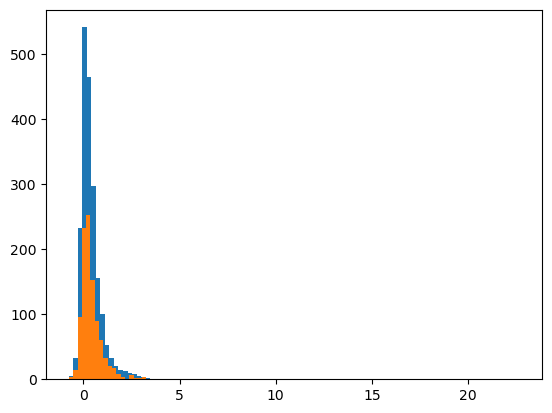

In [110]:
### check if random.choice works

params=best_dist[1]

# Parameters for the generalized hyperbolic distribution
arg = params[:-2]
loc = params[-2]
scale = params[-1]
location = 0.0  # Set the location parameter if needed

# Generate random samples from the generalized hyperbolic distribution
n_samples = 2000  # Choose the number of samples you want to generate
samples = best_dist[0].rvs(*arg, loc=0.0, scale=scale, size=n_samples)
choi=np.random.choice(samples,1000)
plt.hist(samples,100)
plt.hist(choi,100)
# N

### Distributions of the Amplitude of outliers (Histograms)

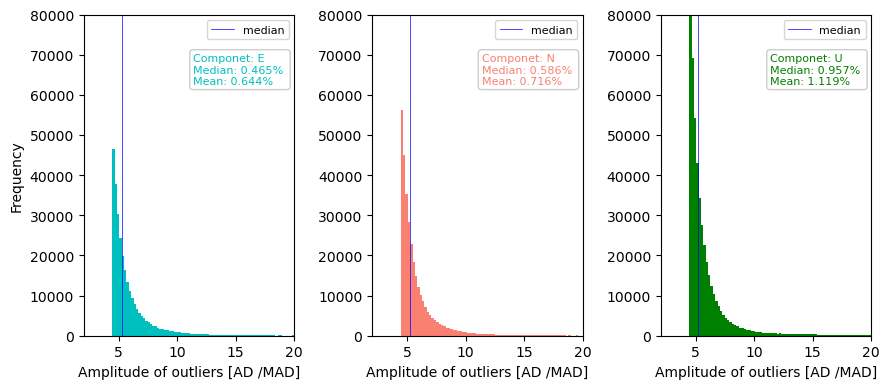

In [72]:
fig, axs = plt.subplots(1,len(components), sharey=False, tight_layout=True,figsize=(9,4))

colors=['c','salmon','g']
bin1=np.linspace(0,20,100)
bin2=np.linspace(0,20,100)
bin3=np.linspace(0,20,100)
binT=[bin1,bin2,bin3]


for z in range(len(components)):
    axs[z].hist(ratiosComponents[z],bin3, color=colors[z])
    props = dict(boxstyle='round', facecolor='w', alpha=0.2)
    axs[z].text(0.52, 0.88, 'Componet: '+str(components[z])+'\nMedian: '+str(round(np.median(np.array(ratiosStations)[:,z]),3))+'% \nMean: '+str(round(np.mean(np.array(ratiosStations)[:,z]),3))+'%', transform= axs[z].transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[z])
    #axs[z].axvline(x=np.mean(np.array(ratiosComponents[z])),label='mean',color='r',linewidth=0.5)
    axs[z].axvline(x=np.median(np.array(ratiosComponents[z])),label='median',color='b',linewidth=0.5)
    axs[z].set_xlabel('Amplitude of outliers [AD /MAD]')
    axs[z].set_ylim(0,80000)
    axs[z].legend(loc='upper right',fontsize=8)
    axs[z].set_xlim(2,20)
axs[0].set_ylabel('Frequency')

fig.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Frequency_outliers.pdf')   

### Fitting Distributions of the Amplitude of outliers (Histograms)

In [ ]:
Save_flag_list=False
Save_flag_plot=False

fig, axes = plt.subplots(2,len(components), sharey=False, tight_layout=True,figsize=(10,6))
plt.subplots_adjust(wspace=0, hspace=0)

best_distT=[]
for i in range(len(components)):
    data = pd.Series(ratiosComponents[i][ratiosComponents[i]<20])

    # Plot for comparison
    ax1 = data.plot(kind='hist', bins=100, density=True, ax=axes[0,i],alpha=0.5, color=colors[i])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax1)
    best_dist = best_distibutions[0]
    
    # Update plots
    ax1.set_ylim(dataYLim)
    ax1.set_title(u'Amplitude of outliers [AD /MAD] \n All Fitted Distributions',fontsize=8)
    ax1.set_xlabel(u'Amplitude of outliers [AD /MAD]',fontsize=8)
    ax1.set_ylabel('Frequency',fontsize=8)

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])
    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)
    
    # Display
    ax2 = pdf.plot(lw=1, ax=axes[1,i],label='PDF-'+str(best_dist[0].name))
    data.plot(kind='hist', bins=100, density=True, alpha=0.9, label='Data', ax=ax2,color=colors[i])
     
    ax2.axvline(x=np.mean(data),label='mean',color='r',linewidth=0.5)
    ax2.axvline(x=np.median(data),label='median',color='b',linewidth=0.5)
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.2)
    # place a text box in upper left in axes coords
    ax2.text(0.50, 0.62, 'Componet: '+str(components[i])+'\nMedian: '+str(round(np.median(data),3))+'% \nMean: '+str(round(np.mean(data),3))+'%', transform= ax2.transAxes, fontsize=8,
                 verticalalignment='top', bbox=props,color=colors[i])
    ax2.legend(loc='upper right',fontsize=8)

    ax2.set_title(u'Amplitude of outliers with best fit distribution',fontsize=8)
    ax2.set_xlabel('Amplitude of outliers [AD /MAD]',fontsize=8)
    ax2.set_ylabel('Frequency',fontsize=8)
    best_distT.append(best_dist)

if Save_flag_list==True:
    with open('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Best_distributions_amplitude_outliers.pkl', 'wb') as file:
        pickle.dump(best_distT, file) 
        
if Save_flag_plot==True:
    plt.savefig('/Users/giacomomastella/Documents/PhD_giacomo/Denoiser/handle_outliers/Best_distributions.pdf')

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

In [46]:

for i 

MAD = median(abs(y(i-w:i+w)-median(y(i-w):y(i+w)))))
         

SyntaxError: invalid syntax (239209111.py, line 1)